# PROGRAM KLASIFIKASI KOIN RUPIAH MENGGUNAKAN METODE RANDOM FOREST 

- M. Daud Abdul Azis – 1203230006
- Wicipto Setiadi – 1203230042
- Moch. Rama Maulana – 1203232085 

Masalah utama yang ingin diselesaikan dalam project ini adalah otomatisasi perhitungan nilai total mata uang koin Rupiah dari sebuah citra.
Dataset yang digunakan berupa gabungan dari dua dataset yang di dapat dari Kaggle:
- https://www.kaggle.com/datasets/wanderdust/coin-images/code
- https://www.kaggle.com/datasets/ameeeliaas/klasifikasi-koin


## Import Library

In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Fungsi Ekstraksi Fitur (HOG + Statistik Intensitas)

Histogram of Oriented Gradients (HOG) dipilih karena sangat efektif untuk menangkap bentuk dan tepi objek, yang merupakan ciri utama pembeda antar nominal koin. HOG merepresentasikan citra sebagai pola arah gradien, sehingga model lebih fokus pada struktur visual koin dan tidak terlalu sensitif terhadap perubahan warna atau pencahayaan.

Pada project ini, HOG bekerja dengan mengubah citra ke grayscale lalu di-resize menjadi 128×128 agar semua input seragam. Kemudian fitur HOG diekstraksi untuk menangkap pola tepi dan bentuk koin. Nilai rata-rata dan standar deviasi intensitas juga ditambahkan sebagai informasi global pencahayaan. Semua fitur digabung menjadi satu vektor untuk input model.

L2-Norm dipilih untuk menjaga skala fitur tetap seimbang sehingga tidak didominasi oleh nilai gradien yang besar.

In [32]:
from skimage.feature import hog

def extract_features(img):
    """
    Ekstraksi fitur dari citra:
    - HOG
    - Mean intensity
    - Standard deviation intensity
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))

    # Ekstrak HOG
    hog_features = hog(
        gray,
        orientations=18,
        pixels_per_cell=(8, 8),
        cells_per_block=(10, 10),
        block_norm='L2-Hys',
        feature_vector=True
    )

    # Opsional: tambahkan fitur global
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)

    # Gabungkan
    features = np.hstack([hog_features, mean_intensity, std_intensity])
    return features

## Visualisasi HOG

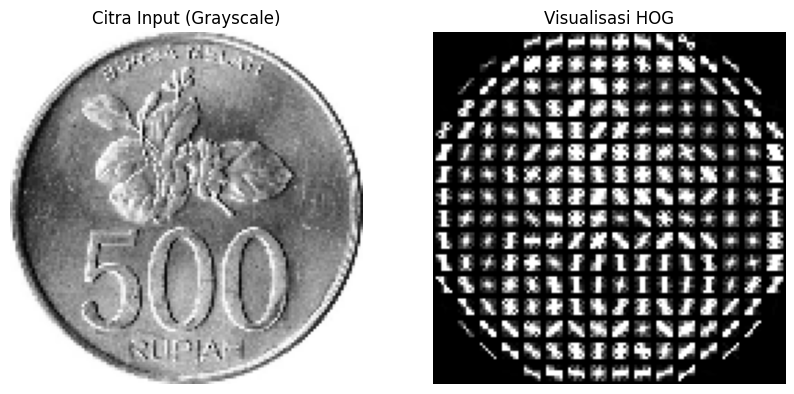

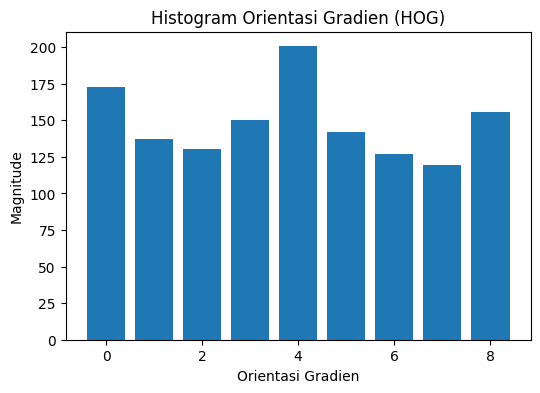

In [ ]:
from skimage import exposure
import pandas as pd

sample_path = os.path.join("dataset3/train/500/IMG_500_003.jpg")

if sample_path:
    img = cv2.imread(sample_path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 128))
        
        # Ekstrak HOG dengan visualize=True
        hog_features, hog_image = hog(
            gray,
            orientations=18,
            pixels_per_cell=(8, 8),
            cells_per_block=(10, 10),
            block_norm='L2-Hys',
            feature_vector=True,
            visualize=True
        )

        # Plot hasilnya
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(gray, cmap=plt.cm.gray)
        ax1.set_title('Citra Input (Grayscale)')

        # Rescale histogram of gradients for better visibility
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Visualisasi HOG')

        plt.tight_layout()
        plt.show()

        # Hitung dimensi HOG
        cells_per_row = 128 // 8  # 16 cells per row
        cells_per_col = 128 // 8  # 16 cells per column
        blocks_per_row = cells_per_row - 10 + 1  # 7 blocks
        blocks_per_col = cells_per_col - 10 + 1  # 7 blocks
        
        total_blocks = blocks_per_row * blocks_per_col
        features_per_block = 10 * 10 * 18  # cells_per_block * cells_per_block * orientations
        
        print(f"Total fitur HOG: {len(hog_features)}")
        print(f"Total blok: {total_blocks}")
        print(f"Fitur per blok: {features_per_block}")
        
        # Reshape dan hitung histogram orientasi (aggregasi sederhana)
        # Setiap 18 nilai = histogram untuk 1 cell
        hog_reshaped = hog_features.reshape(-1, 18)
        hog_hist = hog_reshaped.sum(axis=0)

        # Plot histogram orientasi
        plt.figure(figsize=(10, 5))
        orientations_degrees = np.arange(0, 180, 10)  # 18 bins = 0-170 degrees
        plt.bar(orientations_degrees, hog_hist, width=8, edgecolor='black')
        plt.xlabel("Orientasi Gradien (derajat)")
        plt.ylabel("Magnitude Total")
        plt.title("Histogram Orientasi Gradien (HOG) - 18 Bins")
        plt.xticks(orientations_degrees)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Buat tabel statistik HOG
        hog_stats = pd.DataFrame({
            'Orientasi (derajat)': orientations_degrees,
            'Magnitude': hog_hist,
            'Persentase (%)': (hog_hist / hog_hist.sum() * 100).round(2)
        })
        
        print("\n" + "="*60)
        print("TABEL STATISTIK HISTOGRAM ORIENTASI GRADIEN (HOG)")
        print("="*60)
        print(hog_stats.to_string(index=False))
        print("="*60)
        print(f"\nTotal Magnitude: {hog_hist.sum():.2f}")
        print(f"Mean Magnitude: {hog_hist.mean():.2f}")
        print(f"Std Magnitude: {hog_hist.std():.2f}")
        print(f"Orientasi Dominan: {orientations_degrees[np.argmax(hog_hist)]}° (Magnitude: {hog_hist.max():.2f})")
        
        # Tabel ringkasan fitur HOG
        hog_summary = pd.DataFrame({
            'Parameter': [
                'Ukuran Gambar',
                'Ukuran Cell',
                'Ukuran Block',
                'Jumlah Orientasi',
                'Block Normalisasi',
                'Jumlah Cell (row x col)',
                'Jumlah Block (row x col)',
                'Total Fitur HOG'
            ],
            'Nilai': [
                '128 x 128 pixels',
                '8 x 8 pixels',
                '10 x 10 cells',
                '18',
                'L2-Hys',
                f'{cells_per_row} x {cells_per_col} = {cells_per_row * cells_per_col}',
                f'{blocks_per_row} x {blocks_per_col} = {total_blocks}',
                f'{len(hog_features)}'
            ]
        })
        
        print("\n" + "="*60)
        print("RINGKASAN PARAMETER DAN DIMENSI HOG")
        print("="*60)
        print(hog_summary.to_string(index=False))
        print("="*60)
        
    else:
        print(f"Gagal memuat gambar dari {sample_path}")
else:
    print("Gagal mendapatkan path gambar sampel untuk visualisasi HOG.")

## Inisiasi Folder Dataset & Class

In [34]:
data = []
labels = []

base = "dataset3/train"
classes = ["50", "100", "200", "500", "1000"]

## Load Dataset & Extract Feature

In [35]:
for cls in classes:
  folder = os.path.join(base, cls)
  for file in os.listdir(folder):
    path = os.path.join(folder, file)
    img = cv2.imread(path)

    if img is None:
      continue

    feat = extract_features(img) 
    data.append(feat)
    labels.append(cls)

data = np.array(data)
labels = np.array(labels)

## Statistik Awal Dataset

In [36]:
from collections import Counter

print("### STATISTIK DATASET AWAL ###")
print(f"Total Sampel: {len(data)}")
print("Distribusi Kelas Awal:")

# Menghitung distribusi kelas (Counter(labels) akan menghasilkan: {'1000': 245, '500': 240, ...})
initial_counts = Counter(labels)

# Print berdasarkan urutan nominal
for cls in sorted(classes, key=int):
    count = initial_counts.get(cls, 0)
    print(f"- Kelas {cls}: {count} sampel")

### STATISTIK DATASET AWAL ###
Total Sampel: 904
Distribusi Kelas Awal:
- Kelas 50: 28 sampel
- Kelas 100: 189 sampel
- Kelas 200: 201 sampel
- Kelas 500: 239 sampel
- Kelas 1000: 247 sampel


## Splitting Dataset & Statistik

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
  data, labels, test_size=0.2, random_state=42, stratify=labels
)

print("### STATISTIK PEMBAGIAN DATA ###")
print(f"Ukuran Data Traint (Training Set): {len(X_train)} sampel")
print(f"Ukuran Data Test (Testing Set): {len(X_test)} sampel")

train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("\nDistribusi Kelas (Data Train):")
for cls in sorted(classes, key=int):
    print(f"- Kelas {cls}: {train_counts.get(cls, 0)} sampel")

print("\nDistribusi Kelas (Data Test):")
for cls in sorted(classes, key=int):
    print(f"- Kelas {cls}: {test_counts.get(cls, 0)} sampel")

### STATISTIK PEMBAGIAN DATA ###
Ukuran Data Traint (Training Set): 723 sampel
Ukuran Data Test (Testing Set): 181 sampel

Distribusi Kelas (Data Train):
- Kelas 50: 22 sampel
- Kelas 100: 151 sampel
- Kelas 200: 161 sampel
- Kelas 500: 191 sampel
- Kelas 1000: 198 sampel

Distribusi Kelas (Data Test):
- Kelas 50: 6 sampel
- Kelas 100: 38 sampel
- Kelas 200: 40 sampel
- Kelas 500: 48 sampel
- Kelas 1000: 49 sampel


## Training & Prediksi Model dan Evaluasi

Project ini menggunakan RandomForest karena RandomForest cocok untuk data fitur HOG yang berdimensi tinggi dan bisa memberi hasil cukup baik tanpa tuning rumit.

Kelebihan RandomForest:
- Lebih tahan overfitting dibanding decision tree tunggal 
- Stabil terhadap noise pada data citra 
- Akurasi cukup baik dengan proses training relatif cepat

Cara kerjanya adalah dengan menggunakan fitur HOG sebagai input, lalu RandomForest membangun banyak pohon keputusan saat training. Saat testing, setiap pohon memberi prediksi kelas koin, dan hasil akhir diambil dari voting mayoritas semua pohon. Jumlah pohon ditentukan oleh parameter `n_estimators` dan `random_state` bekerja sebagai seeder. 

In [38]:
import joblib

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("\n### CLASSIFICATION REPORT (DATA UJI INTERNAL) ###")
print(classification_report(y_test, pred))

joblib.dump(model, "coin_rf.pkl")


### CLASSIFICATION REPORT (DATA UJI INTERNAL) ###
              precision    recall  f1-score   support

         100       0.61      0.29      0.39        38
        1000       0.62      0.78      0.69        49
         200       0.67      0.65      0.66        40
          50       1.00      0.67      0.80         6
         500       0.53      0.65      0.58        48

    accuracy                           0.61       181
   macro avg       0.69      0.61      0.62       181
weighted avg       0.62      0.61      0.60       181



['coin_rf.pkl']

## Test Akurasi Dengan Folder

In [39]:
correct = 0
total = 0

base = "dataset3/test"

for cls in classes:
  folder = os.path.join(base, cls)
  for file in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, file))
    
    if img is None:
      continue

    feat = extract_features(img).reshape(1, -1)
    pred = model.predict(feat)[0]

    print(file, "=> pred:", pred, " | true:", cls)

    total += 1
    correct += (pred == cls)

print("\nAccuracy test folder:", correct / total)

IMG_50_000.jpg => pred: 50  | true: 50
IMG_50_001.jpg => pred: 50  | true: 50
IMG_50_002.jpg => pred: 50  | true: 50
IMG_50_003.jpg => pred: 50  | true: 50
IMG_100_000.jpg => pred: 100  | true: 100
IMG_100_001.jpg => pred: 100  | true: 100
IMG_100_002.jpg => pred: 100  | true: 100
IMG_100_003.jpg => pred: 100  | true: 100
IMG_200_000.jpg => pred: 200  | true: 200
IMG_200_001.jpg => pred: 100  | true: 200
IMG_200_002.jpg => pred: 200  | true: 200
IMG_200_003.jpg => pred: 200  | true: 200
IMG_500_000.jpg => pred: 500  | true: 500
IMG_500_001.jpg => pred: 500  | true: 500
IMG_500_002.jpg => pred: 500  | true: 500
IMG_500_003.jpg => pred: 200  | true: 500
IMG_1000_000.jpg => pred: 100  | true: 1000
IMG_1000_001.jpg => pred: 100  | true: 1000
IMG_1000_002.jpg => pred: 500  | true: 1000
IMG_1000_003.jpg => pred: 1000  | true: 1000

Accuracy test folder: 0.75


## Aplikasi Gradio (PCD)

In [40]:
import gradio as gr
import cv2
import numpy as np
import joblib
from collections import Counter

# Load model
model = joblib.load("coin_rf.pkl")

# Label koin dan nilainya
coin_values = {
    '50': 50,
    '100': 100,
    '200': 200,
    '500': 500,
    '1000': 1000
}

# Fungsi deteksi koin (dilingkari)
def detect_coins(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    morph = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)

    cnts, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circles = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 2500:
            continue

        (x, y), r = cv2.minEnclosingCircle(c)
        circles.append((int(x), int(y), int(r)))

    return circles

def detect_and_label(image):
    if image is None:
        return None, ""

    img = image.copy()
    circles = detect_coins(img)

    predictions = []
    label_text = ""

    if not circles:
        label_text = "❌ Tidak ada koin terdeteksi."
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb, label_text

    label_text += f"✅ Terdeteksi {len(circles)} koin\n\n"
    label_text += "Hasil Klasifikasi:\n"
    label_text += "-" * 40 + "\n\n"

    for i, (x, y, r) in enumerate(circles, 1):
        x1 = max(0, x - r)
        y1 = max(0, y - r)
        x2 = min(img.shape[1], x + r)
        y2 = min(img.shape[0], y + r)

        coin = img[y1:y2, x1:x2]
        if coin.size == 0:
            continue

        feat = extract_features(coin).reshape(1, -1)
        pred = model.predict(feat)[0]
        proba = model.predict_proba(feat)[0]

        classes = model.classes_
        prob_with_label = list(zip(classes, proba))
        prob_with_label.sort(key=lambda x: x[1], reverse=True)
        top3 = prob_with_label[:3]

        predictions.append(pred)

        label_text += f"Koin {i}: {pred}\n"
        label_text += "  Top 3 predictions:\n"
        for label, conf in top3:
            label_text += f"    {label:5} : {conf*100:6.1f}%\n"
        label_text += "\n"

    label_text += "=" * 40 + "\n\n"
    label_text += "Ringkasan:\n"

    counter = Counter(predictions)
    total_value = 0
    for coin, count in counter.items():
        nominal = coin_values.get(coin, 0)
        total_value += nominal * count
        label_text += f"- {coin}: {count}x = Rp {nominal * count:,}\n"

    label_text += f"\n💰 TOTAL NILAI: Rp {total_value:,}"

    # Gambar hasil
    for (x, y, r), pred in zip(circles, predictions):
        cv2.circle(
            img, 
            (x, y), 
            r, 
            (0, 255, 0), 
            3
        )
        cv2.putText(
            img, 
            pred, (x - r, y - r - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (255, 0, 0), 
            3
        )

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb, label_text


with gr.Blocks() as demo:
    gr.Markdown("## Deteksi & Klasifikasi Koin Rupiah — RandomForest")

    with gr.Row():
        with gr.Column():
            inp = gr.Image(type="numpy", label="Upload Gambar")
            btn = gr.Button("Deteksi Koin")

        with gr.Column():
            out_img = gr.Image(type="numpy", label="Hasil Deteksi")
            out_text = gr.Textbox(label="Ringkasan Hasil", lines=15, max_lines=25)

    btn.click(detect_and_label, inputs=inp, outputs=[out_img, out_text])

demo.launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


## Kesimpulan

Project masih memiliki masalah, kemungkinan ini disebabkan karena datasetnya kurang seimbang sehingga model cenderung condong ke satu kelas, perlu perbaikan pada model juga karena masih kurang optimal. Selain itu pada program PCD perlu dilakukan peningkatan sehingga noise tidak ikut dimasukkan ke deteksi.